This notebook is for inference using fine-tuned DeBERTa-v3-small model. It's reproducible if the PATHS class is set up correctly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install datasets

# Set up

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
import warnings
import numpy as np, pandas as pd
import random
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
warnings.simplefilter('ignore')

In [4]:
class PATHS:
    save = '/content/drive/MyDrive'
    test = f'{save}/harm_test.tsv'
    save_model = f'{save}/harm-deberta-v3-small'

In [5]:
class CFG:
    max_length = 512
    model_name = 'microsoft/deberta-v3-small'
    labels = ['self_harm', 'harming_others', 'harmed_by_others','reference_to_harm']

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

In [7]:
sigmoid = torch.nn.Sigmoid()

# Load Test Data

In [8]:
test = pd.read_csv(PATHS.test, sep='\t')

In [9]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

In [10]:
def tokenize_function(batch):
    tokenized_inputs = tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=CFG.max_length,
    )
    batch_labels = {label: batch[label] for label in CFG.labels}
    matrix_labels = np.zeros((len(batch['text']), len(CFG.labels)))
    for i, label in enumerate(CFG.labels):
        matrix_labels[:, i] = batch_labels[label]
    tokenized_inputs['labels'] = matrix_labels
    return tokenized_inputs

In [11]:
test_dict = {}
for col in ['id', 'text'] + CFG.labels:
    test_dict[col] = test[col].tolist()

In [12]:
test_ds = Dataset.from_dict(test_dict)
tokenized_test_ds = test_ds.map(tokenize_function, batched=True)
tokenized_test_ds.set_format('torch')

Map:   0%|          | 0/14266 [00:00<?, ? examples/s]

# Load Model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(PATHS.save_model)
trainer = Trainer(model)

# Inference on Test Set

In [14]:
pred = trainer.predict(tokenized_test_ds)

In [15]:
y_true = pred.label_ids
y_proba = sigmoid(torch.Tensor(pred.predictions)).numpy()

Get AUC, ROC curve, classification report, and confusion matrix. We classify each label with the standard 0.5 threshold.

In [16]:
y_pred = np.where(y_proba >= 0.5, 1, 0)

AUC for self_harm: 0.99699791990533


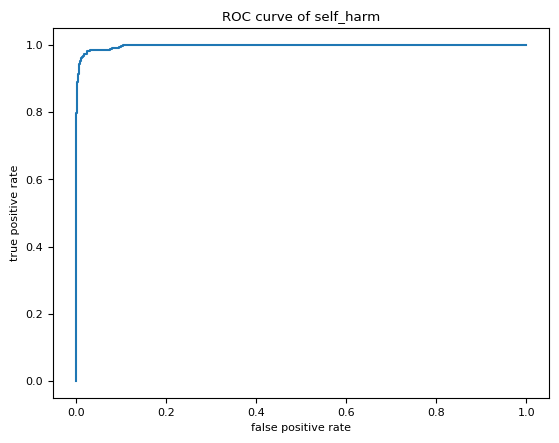

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13954
         1.0       0.87      0.84      0.86       312

    accuracy                           0.99     14266
   macro avg       0.93      0.92      0.93     14266
weighted avg       0.99      0.99      0.99     14266



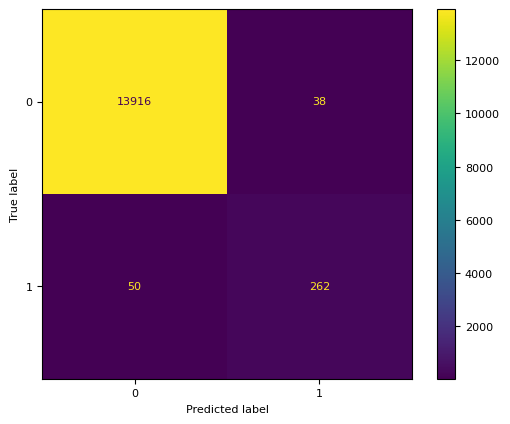



AUC for harming_others: 0.989067314210698


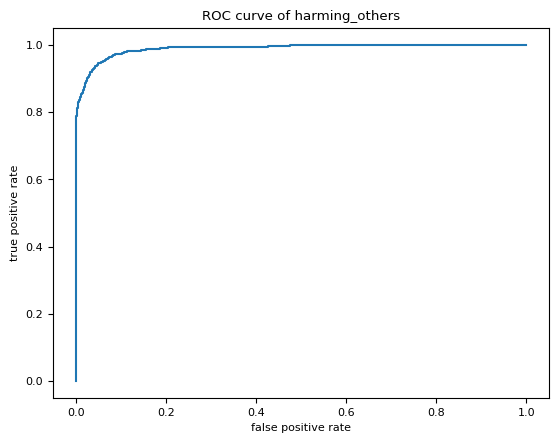

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     13436
         1.0       0.97      0.75      0.85       830

    accuracy                           0.98     14266
   macro avg       0.98      0.87      0.92     14266
weighted avg       0.98      0.98      0.98     14266



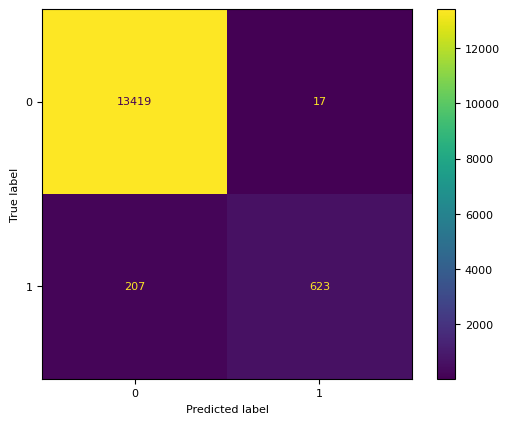



AUC for harmed_by_others: 0.996396160366811


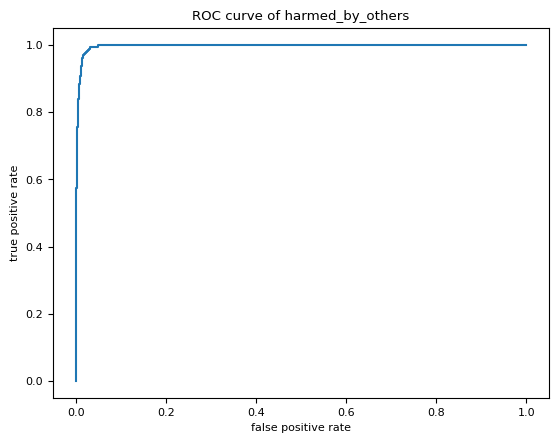

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     13708
         1.0       0.84      0.84      0.84       558

    accuracy                           0.99     14266
   macro avg       0.91      0.92      0.92     14266
weighted avg       0.99      0.99      0.99     14266



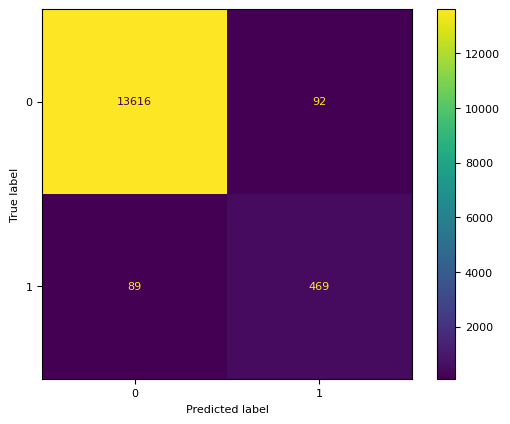



AUC for reference_to_harm: 0.9886735349029747


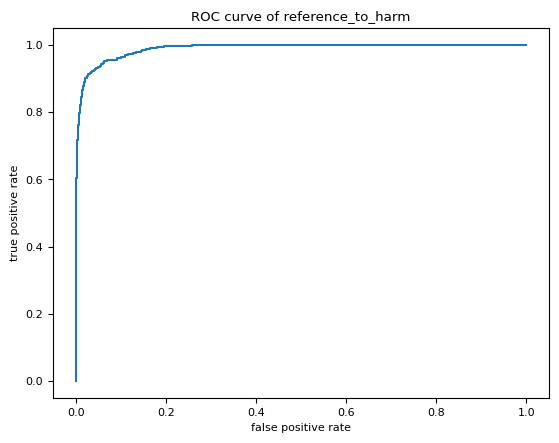

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13926
         1.0       0.83      0.68      0.75       340

    accuracy                           0.99     14266
   macro avg       0.91      0.84      0.87     14266
weighted avg       0.99      0.99      0.99     14266



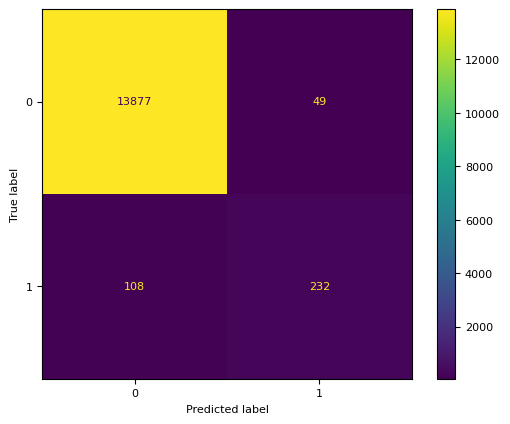

In [17]:
plt.rcParams.update({'font.size': 8})
for i in range(len(CFG.labels)):
    # get auc
    auc = roc_auc_score(y_true[:, i], y_proba[:, i])
    print(f"AUC for {CFG.labels[i]}: {auc}")
    # plot roc curve
    fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
    plt.title(f"ROC curve of {CFG.labels[i]}")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.plot(fpr, tpr)
    plt.show()
    # print classification report
    print(classification_report(y_true[:, i], y_pred[:, i]))
    # display confusion matrix
    cm = confusion_matrix(y_true[:, i], y_pred[:, i])
    cmdisplay = ConfusionMatrixDisplay(cm)
    cmdisplay.plot()
    plt.show()
    print('\n')

We derive the optimal threshold by maximizing the F1-score for each label. Since we derived it from the test set we cannot use it to classify the the test set, but we can use it for classifying examples outside of the test set.

In [18]:
optimal_thresholds = np.zeros(len(CFG.labels))
for i in range(len(CFG.labels)):
    # get optimal threshold by maximizing f1
    precision, recall, threshold = precision_recall_curve(y_true[:, i], y_proba[:, i])
    optimal_index = np.argmax(2*precision*recall/(precision+recall))
    optimal_threshold = threshold[optimal_index]
    optimal_thresholds[i] = optimal_threshold
    print(f"Optimal threshold for {CFG.labels[i]}: {optimal_threshold:.2f}")

Optimal threshold for self_harm: 0.30
Optimal threshold for harming_others: 0.27
Optimal threshold for harmed_by_others: 0.33
Optimal threshold for reference_to_harm: 0.35


# Inference on Examples

In [26]:
text = ["I'm trash", "He's trash", "They told me I'm trash", "He told her she's trash", "My phone is trash"]

In [27]:
tokenized_text = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=CFG.max_length)
tokenized_text = {k: v.to(trainer.model.device) for k, v in tokenized_text.items()}
output = model(**tokenized_text)
logits = output.logits
proba = sigmoid(logits.squeeze().cpu()).detach().numpy()

In [28]:
predicted_labels = np.where(proba >= optimal_thresholds, 1, 0)

In [29]:
result = pd.DataFrame({'text': text})
result[CFG.labels] = predicted_labels
display(result)

,text,self_harm,harming_others,harmed_by_others,reference_to_harm
0,I'm trash,1,0,0,0
1,He's trash,0,1,0,0
2,They told me I'm trash,0,0,1,0
3,He told her she's trash,0,0,0,1
4,My phone is trash,0,0,0,0
